#Document QA using Transformer 

The model used is `DocQuery` which uses LayoutLMv1(Microsoft Transformer) fine-tuned on DocVQA, a document visual question answering dataset, as well as SQuAD, which boosts its English-language comprehension.

In [ ]:
%%capture
!pip install docquery
!pip install transformers==4.24.0
!apt-get install poppler-utils
!pip install -U --no-cache-dir gdown --pre
!pip install pdfservices-sdk
get_ipython().kernel.do_shutdown(True)


In [ ]:
from docquery import  pipeline
from docquery.document import load_document
from tqdm import tqdm

def Document_QA(file_path,questions,num_answers):
  answers=[]
  p = pipeline('document-question-answering', model="impira/layoutlm-document-qa")
  doc = document = load_document(file_path)
  for question in tqdm(questions):
    x=p(question=question, **doc.context,top_k=num_answers)
    answers.append(x)
  return answers

In [ ]:
Document_QA(
    file_path="/content/Nokia_People_and_Planet_Report_2020.pdf",
    questions=["what is the value of Scope 2 Emissions in Tons (Location based) in 2020?"],
    num_answers=3
)

100%|██████████| 1/1 [07:23<00:00, 443.65s/it]


[[{'score': 0.41756105422973633, 'answer': '50%', 'word_ids': [83], 'page': 9},
  {'score': 0.37586450576782227,
   'answer': 'People & Planet',
   'word_ids': [0, 1, 2],
   'page': 0},
  {'score': 0.3524116277694702, 'answer': '31', 'word_ids': [74], 'page': 53}]]

**Note:** The results isn't so great so, this my custimize solution.

#Customize solution 

I note all answers we need is in the tables of Pdf.<br>based on that I create this Pipline


---


1.   Extract tables from pdf using `Adobe Pdf Extractor`
2.   Ask DocQuery based on the tables instead whole of the pdf 
3. Rank the answers based on its scores
4. Preview the answers







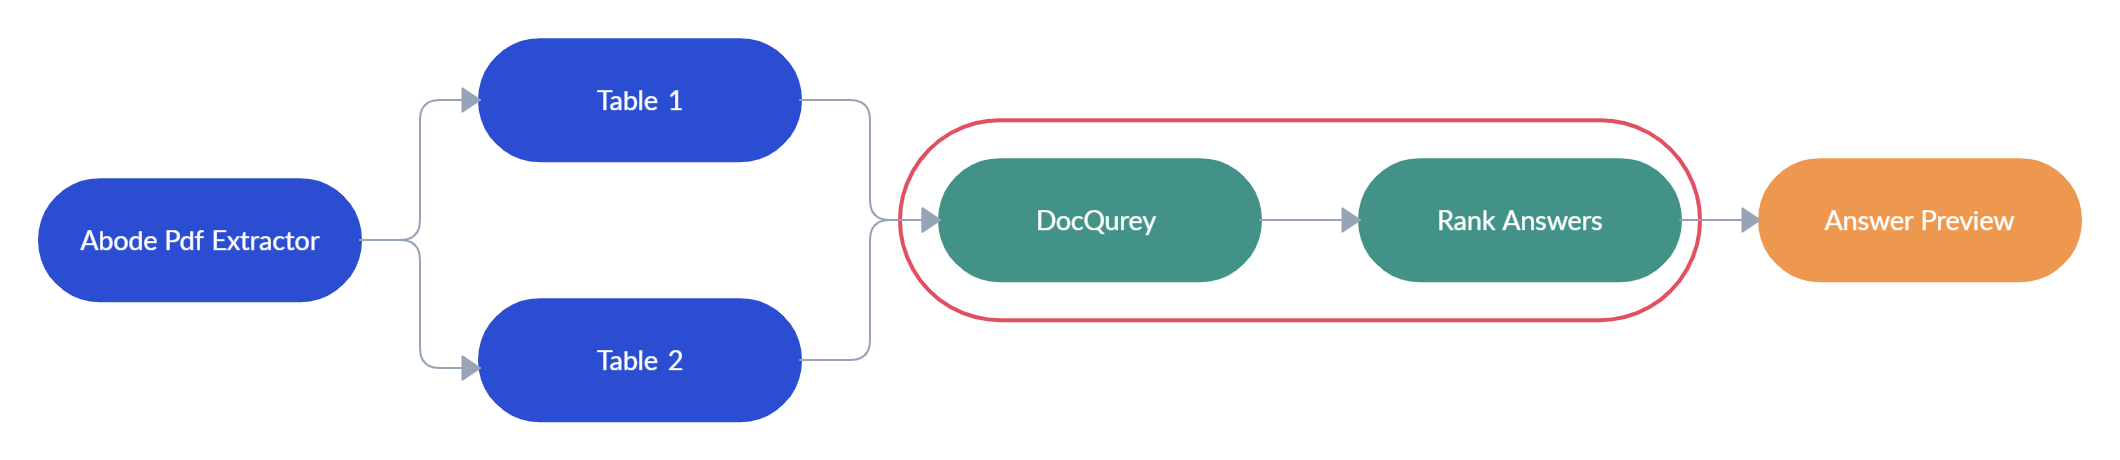

##Adobe Pdf Extractor

Download and extract Credential folder

In [ ]:
! gdown https://drive.google.com/uc?id=16QozC9c7Sxu4wGE6k4LA-nxn_-Z54CJy

!unzip "PDFServicesSDK-Python (Extract)Samples.zip"

Downloading...
From: https://drive.google.com/uc?id=12H_Ewyy05VrfXk2oGxmFgcKQxHabkiA6
To: /content/PDFServicesSDK-Python (Extract)Samples.zip
100% 613k/613k [00:00<00:00, 144MB/s]
Archive:  PDFServicesSDK-Python (Extract)Samples.zip
 extracting: private.key             
 extracting: adobe-dc-pdf-services-sdk-extract-python-samples/CODE_OF_CONDUCT.md  
 extracting: adobe-dc-pdf-services-sdk-extract-python-samples/LICENSE.md  
 extracting: adobe-dc-pdf-services-sdk-extract-python-samples/.DS_Store  
 extracting: adobe-dc-pdf-services-sdk-extract-python-samples/requirements.txt  
 extracting: adobe-dc-pdf-services-sdk-extract-python-samples/README.md  
 extracting: adobe-dc-pdf-services-sdk-extract-python-samples/resources/extractPdfInput.pdf  
 extracting: adobe-dc-pdf-services-sdk-extract-python-samples/resources/autotagPdfInput.pdf  
 extracting: adobe-dc-pdf-services-sdk-extract-python-samples/src/extractpdf/extract_txt_table_info_with_figure_tables_rendition_from_pdf.py  
 extracting

In [ ]:
%%capture
!pip install pdfservices-sdk

In [ ]:
from adobe.pdfservices.operation.auth.credentials import Credentials
from adobe.pdfservices.operation.exception.exceptions import ServiceApiException, ServiceUsageException, SdkException
from adobe.pdfservices.operation.execution_context import ExecutionContext
from adobe.pdfservices.operation.io.file_ref import FileRef
from adobe.pdfservices.operation.pdfops.extract_pdf_operation import ExtractPDFOperation
from adobe.pdfservices.operation.pdfops.options.extractpdf.extract_pdf_options import ExtractPDFOptions
from adobe.pdfservices.operation.pdfops.options.extractpdf.extract_element_type import ExtractElementType
from adobe.pdfservices.operation.pdfops.options.extractpdf.extract_renditions_element_type import \
    ExtractRenditionsElementType
from adobe.pdfservices.operation.pdfops.options.extractpdf.table_structure_type import TableStructureType

import logging
import zipfile
import os

In [ ]:
def extract_tables(file_path):

  file_absolute_name=file_path.split('.')[-2].split('/')[-1]

  os.makedirs(file_absolute_name,exist_ok=True)
  result_path = os.path.join(file_absolute_name,file_absolute_name)
  output_zip = f"{result_path}.zip"

  if os.path.isfile(output_zip):
      os.remove(output_zip)
  
  input_pdf = f"{file_path.split('/')[-1]}"
  try:

      #Initial setup, create credentials instance.
      credentials = Credentials.service_account_credentials_builder()\
          .from_file("/content/adobe-dc-pdf-services-sdk-extract-python-samples/pdfservices-api-credentials.json") \
          .build()

      #Create an ExecutionContext using credentials and create a new operation instance.
      execution_context = ExecutionContext.create(credentials)
      extract_pdf_operation = ExtractPDFOperation.create_new()

      #Set operation input from a source file.
      source = FileRef.create_from_local_file(file_path)
      extract_pdf_operation.set_input(source)

      #Build ExtractPDF options and set them into the operation
      extract_pdf_options: ExtractPDFOptions = ExtractPDFOptions.builder() \
              .with_elements_to_extract([ExtractElementType.TEXT, ExtractElementType.TABLES]) \
              .with_get_char_info(True) \
              .with_elements_to_extract_renditions([ExtractRenditionsElementType.TABLES]) \
              .with_include_styling_info(True) \
              .build()

      extract_pdf_operation.set_options(extract_pdf_options)

      #Execute the operation.
      result: FileRef = extract_pdf_operation.execute(execution_context)

      #Save the result to the specified location.
      result.save_as(output_zip)

      #unzip result file 
      zipfile.ZipFile(output_zip, 'r').extractall(f"{file_absolute_name}")
      result_path= os.path.join(result_path.split("/")[0],"tables")
      print("The Image Tables saved to :",result_path)

      return result_path

  except (ServiceApiException, ServiceUsageException, SdkException):
      logging.exception("Exception encountered while executing operation")


In [ ]:
tables_path=extract_tables("/content/Bayer-Sustainability-Report-2020.pdf")
tables_path

The Image Tables saved to : Bayer-Sustainability-Report-2020/tables


'Bayer-Sustainability-Report-2020/tables'

##Run DocQuery on tables data

In [ ]:
from docquery import document, pipeline
from docquery.document import load_document, ImageDocument
from docquery.ocr_reader import get_ocr_reader
from PIL import Image
import glob
import numpy as np
from tqdm import tqdm
import pandas as pd


def Document_QA_From_Tabeles(tables_path,questions):

  df=pd.DataFrame({"answer":[],"score":[],"table_path":[]})
  
  tables= glob.glob(f"{tables_path}/*.png")

  p = pipeline('document-question-answering', model="impira/layoutlm-document-qa")

  for question in tqdm(questions):

    all_scores=[]
    all_answers=[]
    xs=[]

    for table in tables:
      doc = document.ImageDocument(Image.fromarray(np.asarray(Image.open(table))),get_ocr_reader())
      x=p(question=question, **doc.context,top_k=1)[0]
      all_scores.append(x['score'])
      all_answers.append(x['answer'])
      xs.append(x)

    index=np.argsort(all_scores)[:][::-1]

    for i in index:
      if all_answers[i].replace(" ","").isdigit():
         df.loc[question]=[all_answers[i],all_scores[i],tables[i]]
         break
      else: continue
  return df

In [ ]:
Document_QA_From_Tabeles(tables_path="Bayer-Sustainability-Report-2020/tables",
                         questions=[
                             "what is the value of Scope 2 Emissions in Tons (Location based) in 2020?"
                             ,"what is the value of Scope 2 Emissions in Tons (Market based) in 2020?"])

  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/transformers/pipelines/base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 2/2 [01:24<00:00, 42.45s/it]


answer  \
what is the value of Scope 2 Emissions in Tons ...  Bayer-Sustainability-Report-2020/tables/fileou...   
what is the value of Scope 2 Emissions in Tons ...  Bayer-Sustainability-Report-2020/tables/fileou...   

                                                      score  table_path  
what is the value of Scope 2 Emissions in Tons ...  250 241    0.999247  
what is the value of Scope 2 Emissions in Tons ...  250 241    0.997975

#Final App

You can just run the two following cell to see results.<br>
The `App Function` takes the path of pdf ,and the question
- it takes about 2 minutes to extract tables from pdf
- it takes about 55 seconds to retrieve a answer for a single query ( almost 7 minute for the whole 8 queries )
                "Scope 1 Emissions in Tons ",
                "Scope 2 Emissions Location-based",
                "Scope 2 Emissions Market-based ",
                "Scope 3 Emissions in Tons ",
                "Total amount of Waste Produced",
                "Total hazardous waste in 2020",
                "Total water usage in 2020",
                "number of Employees in 2020"



In [ ]:
%%capture
!pip install docquery
!pip install transformers==4.24.0
!apt-get install poppler-utils
!pip install -U --no-cache-dir gdown --pre
!pip install pdfservices-sdk
get_ipython().kernel.do_shutdown(True)

In [ ]:
from adobe.pdfservices.operation.auth.credentials import Credentials
from adobe.pdfservices.operation.exception.exceptions import ServiceApiException, ServiceUsageException, SdkException
from adobe.pdfservices.operation.execution_context import ExecutionContext
from adobe.pdfservices.operation.io.file_ref import FileRef
from adobe.pdfservices.operation.pdfops.extract_pdf_operation import ExtractPDFOperation
from adobe.pdfservices.operation.pdfops.options.extractpdf.extract_pdf_options import ExtractPDFOptions
from adobe.pdfservices.operation.pdfops.options.extractpdf.extract_element_type import ExtractElementType
from adobe.pdfservices.operation.pdfops.options.extractpdf.extract_renditions_element_type import \
    ExtractRenditionsElementType
from adobe.pdfservices.operation.pdfops.options.extractpdf.table_structure_type import TableStructureType
import logging
import zipfile
import os

from docquery import document, pipeline
from docquery.document import load_document, ImageDocument
from docquery.ocr_reader import get_ocr_reader
from PIL import Image,ImageDraw
import glob
import numpy as np
from tqdm import tqdm
import pandas as pd
import gdown
import matplotlib.pyplot as plt


def extract_tables(file_path):

  file_absolute_name=file_path.split('.')[-2].split('/')[-1]
  os.makedirs(file_absolute_name,exist_ok=True)
  result_path = os.path.join(file_absolute_name,file_absolute_name)
  output_zip = f"{result_path}.zip"

  if os.path.isfile(output_zip):
      os.remove(output_zip)
  
  input_pdf = f"{file_path.split('/')[-1]}"
  try:

      #Initial setup, create credentials instance.
      credentials = Credentials.service_account_credentials_builder()\
          .from_file("/content/adobe-dc-pdf-services-sdk-extract-python-samples/pdfservices-api-credentials.json") \
          .build()

      #Create an ExecutionContext using credentials and create a new operation instance.
      execution_context = ExecutionContext.create(credentials)
      extract_pdf_operation = ExtractPDFOperation.create_new()

      #Set operation input from a source file.
      source = FileRef.create_from_local_file(file_path)
      extract_pdf_operation.set_input(source)

      #Build ExtractPDF options and set them into the operation
      extract_pdf_options: ExtractPDFOptions = ExtractPDFOptions.builder() \
              .with_elements_to_extract([ExtractElementType.TEXT, ExtractElementType.TABLES]) \
              .with_get_char_info(True) \
              .with_elements_to_extract_renditions([ExtractRenditionsElementType.TABLES]) \
              .with_include_styling_info(True) \
              .build()

      extract_pdf_operation.set_options(extract_pdf_options)

      #Execute the operation.
      result: FileRef = extract_pdf_operation.execute(execution_context)

      #Save the result to the specified location.
      result.save_as(output_zip)

      #unzip result file 
      zipfile.ZipFile(output_zip, 'r').extractall(f"{file_absolute_name}")
      result_path= os.path.join(result_path.split("/")[0],"tables")
      print("The Image Tables saved to :",result_path)

      return result_path

  except (ServiceApiException, ServiceUsageException, SdkException):
      logging.exception("Exception encountered while executing operation")



def Document_QA_From_Tabeles(tables_path,questions):

  df=pd.DataFrame({"answer":[],"score":[],"table_path":[],"mapped_answer_loaction":[]})
  
  tables= glob.glob(f"{tables_path}/*.png")

  p = pipeline('document-question-answering', model="impira/layoutlm-document-qa")

  for question in tqdm(questions):

    all_scores=[]
    all_answers=[]
    xs=[]

    for table in tables:
      doc = document.ImageDocument(Image.fromarray(np.asarray(Image.open(table))),get_ocr_reader())
      x=p(question=question, **doc.context,top_k=1)[0]
      all_scores.append(x['score'])
      all_answers.append(x['answer'])
      xs.append(x)

    index=np.argsort(all_scores)[:][::-1]

    for i in index:
      if all_answers[i].replace(" ","").isdigit():
         df.loc[question]=[all_answers[i],all_scores[i],tables[i],xs[i]["word_ids"]]
         break
      else: continue
  return df

def App(pdf_path,quries):
  #Download Cerdiential
  gdown.download('https://drive.google.com/uc?id=16QozC9c7Sxu4wGE6k4LA-nxn_-Z54CJy', quiet=False)
  zipfile.ZipFile("PDFServicesSDK-Python (Extract)Samples.zip", 'r').extractall()

  #Extract tables
  tables_path=extract_tables(pdf_path)

  #Answer Quires
  df=Document_QA_From_Tabeles(tables_path,quries)

  return df

########################################################################
########################Previewing Methods##############################
########################################################################

def normalize_bbox(box, width, height, padding=0.005):
    min_x, min_y, max_x, max_y = [c / 1000 for c in box]
    if padding != 0:
        min_x = max(0, min_x - padding)
        min_y = max(0, min_y - padding)
        max_x = min(max_x + padding, 1)
        max_y = min(max_y + padding, 1)
    return [min_x * width, min_y * height, max_x * width, max_y * height]

def lift_word_boxes(document, page):
    return document.context["image"][page][1]


def expand_bbox(word_boxes):
    if len(word_boxes) == 0:
        return None
    min_x, min_y, max_x, max_y = zip(*[x[1] for x in word_boxes])
    min_x, min_y, max_x, max_y = [min(min_x), min(min_y), max(max_x), max(max_y)]
    return [min_x, min_y, max_x, max_y]

def preview_answer(answer_row):
    doc = document.ImageDocument(Image.fromarray(np.asarray(Image.open(answer_row["table_path"]))),get_ocr_reader())
    pages = [x.copy().convert("RGB") for x in doc.preview]
    image = pages[0]
    draw = ImageDraw.Draw(image, "RGBA")
    word_boxes = lift_word_boxes(doc, 0)
    x1, y1, x2, y2 = normalize_bbox(
        expand_bbox([word_boxes[i] for i in answer_row["mapped_answer_loaction"]]),
        image.width,
        image.height,
    )
    draw.rectangle(((x1, y1), (x2, y2)), fill=(0, 255, 0, int(0.4 * 255)))
    return image

def preview_all_answers(answers):
  for i,row_answer in answers.iterrows():
    print(i)
    plt.figure(figsize=(20,8))
    plt.imshow(preview_answer(row_answer))
    plt.axis('off')
    plt.show()

Downloading...
From: https://drive.google.com/uc?id=16QozC9c7Sxu4wGE6k4LA-nxn_-Z54CJy
To: /content/PDFServicesSDK-Python (Extract)Samples.zip
100%|██████████| 613k/613k [00:00<00:00, 79.6MB/s]


The Image Tables saved to : Nokia_People_and_Planet_Report_2020/tables


  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/transformers/pipelines/base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/pandas/core/dtypes/cast.py:881: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  element = np.asarray(element)
100%|██████████| 8/8 [07:31<00:00, 56.48s/it]


answer     score  \
what's the value of Scope 1 Emissions in 2020?         116 300  0.502653   
what's the value of Scope 2 Emissions Location-...     380 200  0.997949   
what's the value of Scope 2 Emissions Market-ba...     263 600  0.961823   
what's the value of Scope 3 Emissions in Tons i...  35 595 100  0.665699   
what's the value of Total amount of Waste Produ...       7 900  0.723294   
what's the value of Total hazardous waste in 2020?         700  0.891985   
what's the value of Total water usage in 2020?           1 299  0.995807   
what's the value of number of Employees in 2020?        89 978  0.987092   

                                                                                           table_path  \
what's the value of Scope 1 Emissions in 2020?      Nokia_People_and_Planet_Report_2020/tables/fil...   
what's the value of Scope 2 Emissions Location-...  Nokia_People_and_Planet_Report_2020/tables/fil...   
what's the value of Scope 2 Emissions Market-ba...  Nokia_People_and_Planet_Report_2020/tables/fil...   
what's the value of Scope 3 Emissions in Tons i...  Nokia_People_and_Planet_Report_2020/tables/fil...   
what's the value of Total amount of Waste Produ...  Nokia_People_and_Planet_Report_2020/tables/fil...   
what's the value of Total hazardous waste in 2020?  Nokia_People_and_Planet_Report_2020/tables/fil...   
what's the value of Total water usage in 2020?      Nokia_People_and_Planet_Report_2020/tables/fil...   
what's the value of number of Employees in 2020?    Nokia_People_and_Planet_Report_2020/tables/fil...   

                                                   mapped_answer_loaction  
what's the value of Scope 1 Emissions in 2020?                       [16]  
what's the value of Scope 2 Emissions Location-...                   [75]  
what's the value of Scope 2 Emissions Market-ba...                   [50]  
what's the value of Scope 3 Emissions in Tons i...                  [114]  
what's the value of Total amount of Waste Produ...                   [17]  
what's the value of Total hazardous waste in 2020?                   [94]  
what's the value of Total water usage in 2020?                      [121]  
what's the value of number of Employees in 2020?                     [15]

what's the value of Scope 1 Emissions in 2020?


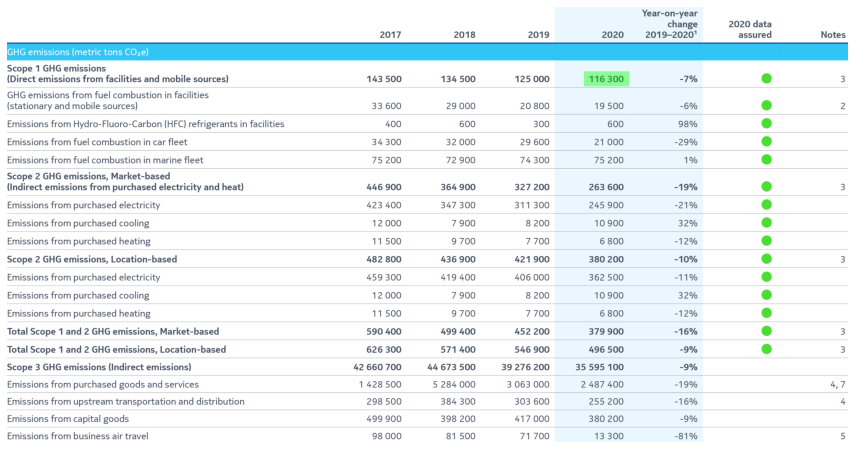

what's the value of Scope 2 Emissions Location-based in 2020?


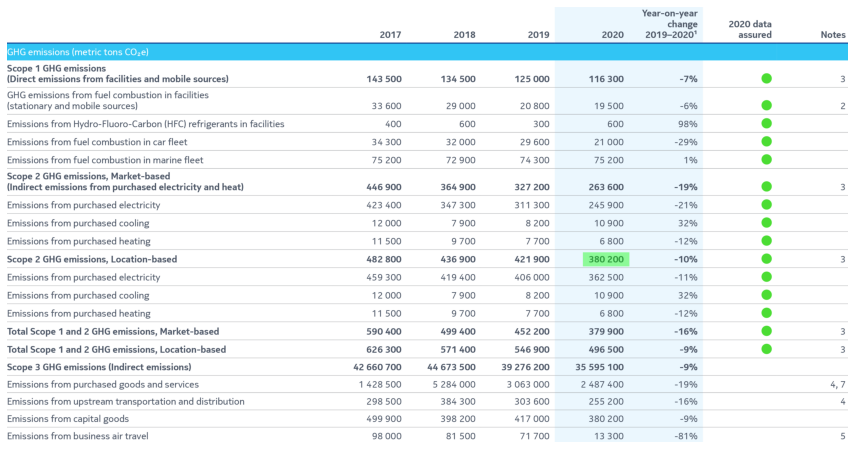

what's the value of Scope 2 Emissions Market-based in 2020?


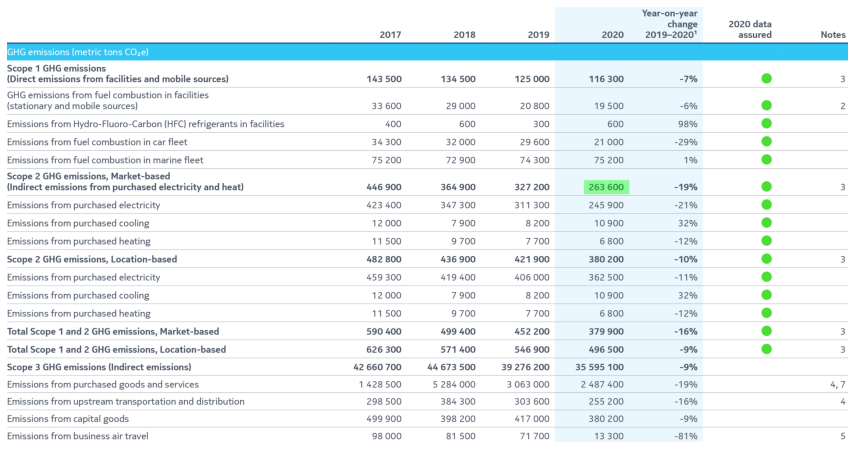

what's the value of Scope 3 Emissions in Tons in 2020?


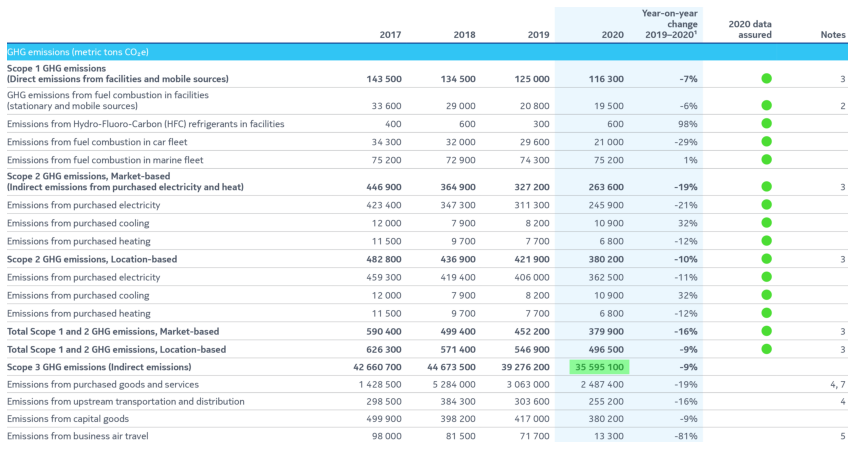

what's the value of Total amount of Waste Produced in 2020?


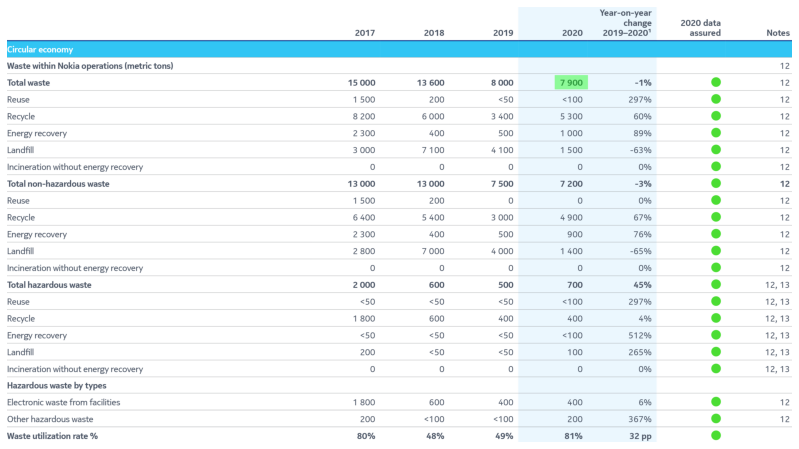

what's the value of Total hazardous waste in 2020?


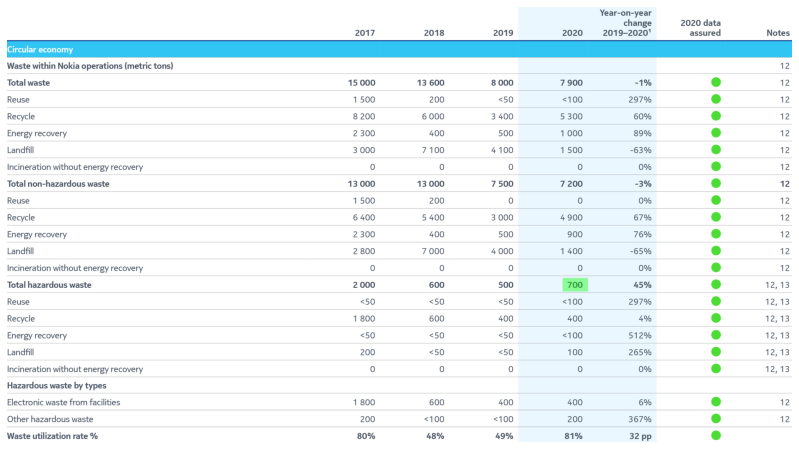

what's the value of Total water usage in 2020?


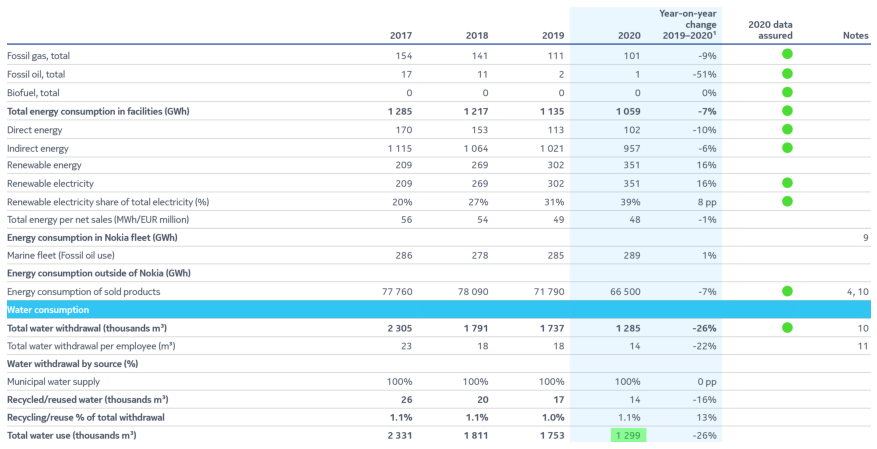

what's the value of number of Employees in 2020?


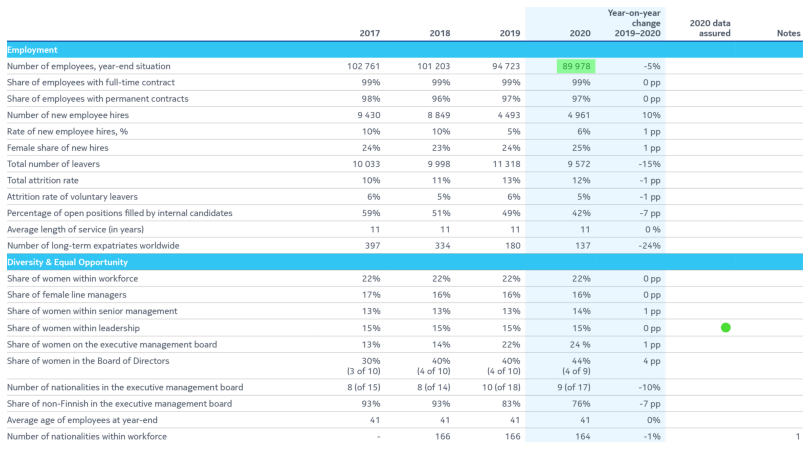

In [ ]:
nokia_answers=App(
    pdf_path="/content/Nokia_People_and_Planet_Report_2020.pdf",
    quries= ["what's the value of Scope 1 Emissions in 2020?",
                "what's the value of Scope 2 Emissions Location-based in 2020?",
                "what's the value of Scope 2 Emissions Market-based in 2020?",
                "what's the value of Scope 3 Emissions in Tons in 2020?",
                "what's the value of Total amount of Waste Produced in 2020?",
                "what's the value of Total hazardous waste in 2020?",
                "what's the value of Total water usage in 2020?",
                "what's the value of number of Employees in 2020?"]
    )

display(nokia_answers)
preview_all_answers(nokia_answers)

Downloading...
From: https://drive.google.com/uc?id=16QozC9c7Sxu4wGE6k4LA-nxn_-Z54CJy
To: /content/PDFServicesSDK-Python (Extract)Samples.zip
100%|██████████| 613k/613k [00:00<00:00, 76.5MB/s]


The Image Tables saved to : shell-sustainability-report-2020/tables


  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/transformers/pipelines/base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/pandas/core/dtypes/cast.py:881: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  element = np.asarray(element)
100%|██████████| 8/8 [07:56<00:00, 59.52s/it]


answer     score  \
what's the value of Scope 1 Emissions in 2020?         98  0.998129   
what's the value of Scope 2 Emissions Location-...     75  0.998613   
what's the value of Scope 2 Emissions Market-ba...     75  0.997965   
what's the value of Scope 3 Emissions in Tons i...     75  0.995829   
what's the value of Total amount of Waste Produ...     75  0.987781   
what's the value of Total hazardous waste in 2020?     75  0.956022   
what's the value of Total water usage in 2020?         75  0.855750   
what's the value of number of Employees in 2020?       11  0.998431   

                                                                                           table_path  \
what's the value of Scope 1 Emissions in 2020?      shell-sustainability-report-2020/tables/fileou...   
what's the value of Scope 2 Emissions Location-...  shell-sustainability-report-2020/tables/fileou...   
what's the value of Scope 2 Emissions Market-ba...  shell-sustainability-report-2020/tables/fileou...   
what's the value of Scope 3 Emissions in Tons i...  shell-sustainability-report-2020/tables/fileou...   
what's the value of Total amount of Waste Produ...  shell-sustainability-report-2020/tables/fileou...   
what's the value of Total hazardous waste in 2020?  shell-sustainability-report-2020/tables/fileou...   
what's the value of Total water usage in 2020?      shell-sustainability-report-2020/tables/fileou...   
what's the value of number of Employees in 2020?    shell-sustainability-report-2020/tables/fileou...   

                                                   mapped_answer_loaction  
what's the value of Scope 1 Emissions in 2020?                       [11]  
what's the value of Scope 2 Emissions Location-...                    [5]  
what's the value of Scope 2 Emissions Market-ba...                    [5]  
what's the value of Scope 3 Emissions in Tons i...                    [5]  
what's the value of Total amount of Waste Produ...                    [5]  
what's the value of Total hazardous waste in 2020?                    [5]  
what's the value of Total water usage in 2020?                        [5]  
what's the value of number of Employees in 2020?                      [2]

what's the value of Scope 1 Emissions in 2020?


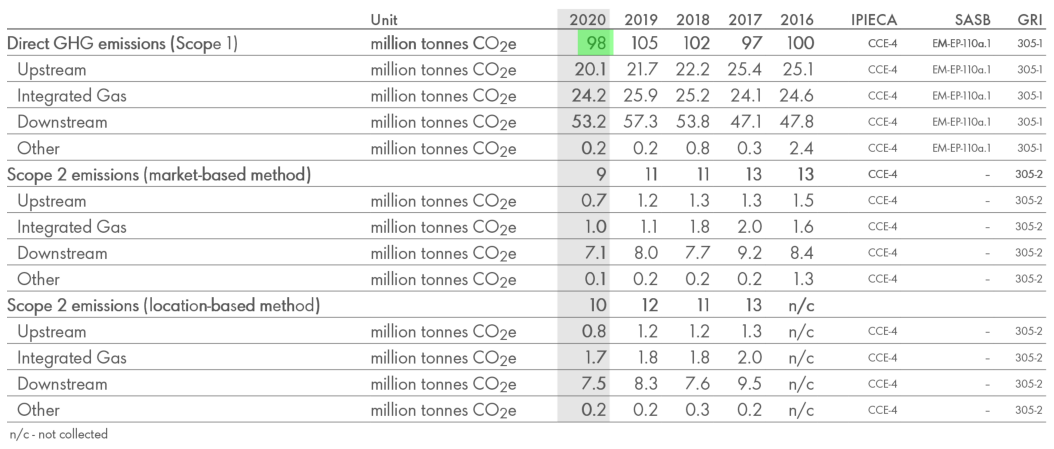

what's the value of Scope 2 Emissions Location-based in 2020?


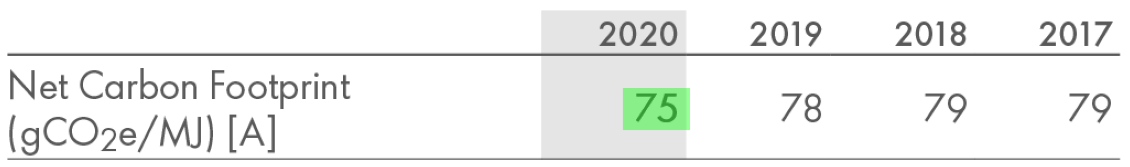

what's the value of Scope 2 Emissions Market-based in 2020?


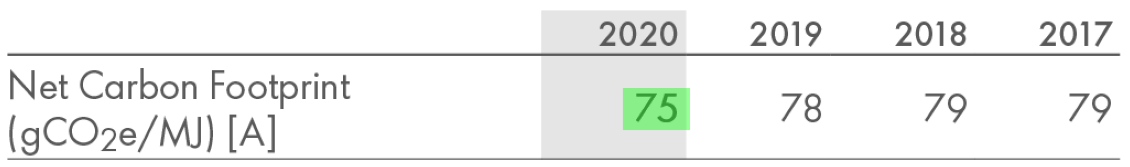

what's the value of Scope 3 Emissions in Tons in 2020?


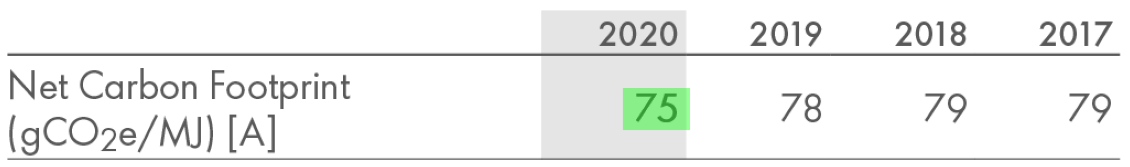

what's the value of Total amount of Waste Produced in 2020?


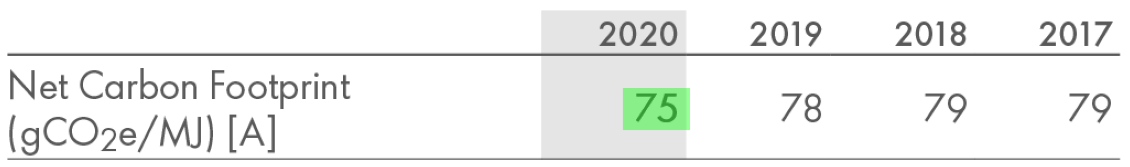

what's the value of Total hazardous waste in 2020?


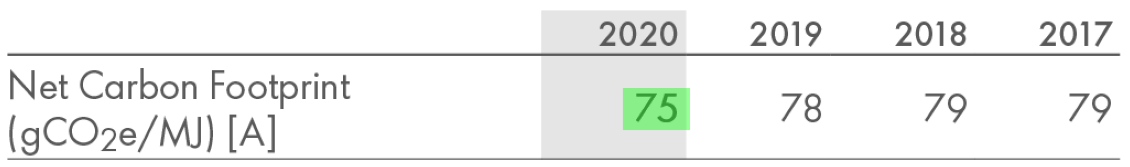

what's the value of Total water usage in 2020?


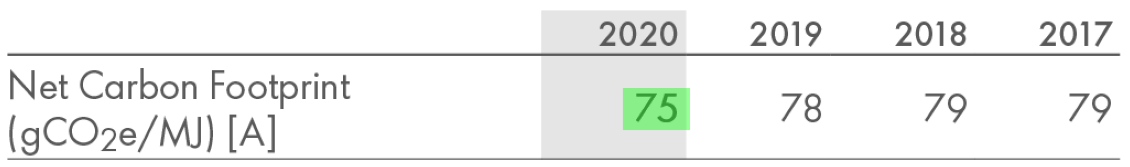

what's the value of number of Employees in 2020?


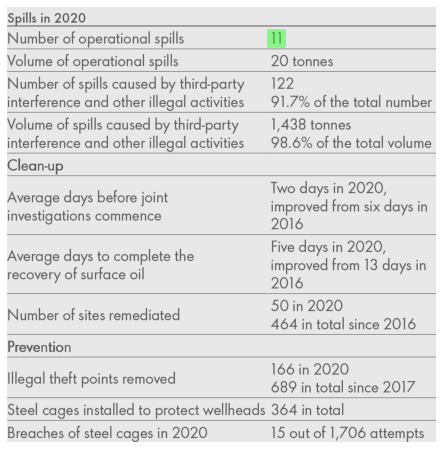

In [ ]:
shell_answers=App(
    pdf_path="/content/shell-sustainability-report-2020.pdf",
    quries= ["what's the value of Scope 1 Emissions in 2020?",
                "what's the value of Scope 2 Emissions Location-based in 2020?",
                "what's the value of Scope 2 Emissions Market-based in 2020?",
                "what's the value of Scope 3 Emissions in Tons in 2020?",
                "what's the value of Total amount of Waste Produced in 2020?",
                "what's the value of Total hazardous waste in 2020?",
                "what's the value of Total water usage in 2020?",
                "what's the value of number of Employees in 2020?"]
    )

display(shell_answers)
preview_all_answers(shell_answers)

Downloading...
From: https://drive.google.com/uc?id=16QozC9c7Sxu4wGE6k4LA-nxn_-Z54CJy
To: /content/PDFServicesSDK-Python (Extract)Samples.zip
100%|██████████| 613k/613k [00:00<00:00, 95.1MB/s]


The Image Tables saved to : Bayer-Sustainability-Report-2020/tables


  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/transformers/pipelines/base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/pandas/core/dtypes/cast.py:881: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  element = np.asarray(element)
100%|██████████| 8/8 [05:31<00:00, 41.40s/it]


answer     score  \
what's the value of Scope 1 Emissions in 2020?      250 241  0.999372   
what's the value of Scope 2 Emissions Location-...       81  0.991984   
what's the value of Scope 2 Emissions Market-ba...       81  0.977340   
what's the value of Scope 3 Emissions in Tons i...       99  0.937760   
what's the value of Total amount of Waste Produ...       25  0.997841   
what's the value of Total hazardous waste in 2020?  250 241  0.982965   
what's the value of Total water usage in 2020?           57  0.984366   
what's the value of number of Employees in 2020?      80 80  0.998165   

                                                                                           table_path  \
what's the value of Scope 1 Emissions in 2020?      Bayer-Sustainability-Report-2020/tables/fileou...   
what's the value of Scope 2 Emissions Location-...  Bayer-Sustainability-Report-2020/tables/fileou...   
what's the value of Scope 2 Emissions Market-ba...  Bayer-Sustainability-Report-2020/tables/fileou...   
what's the value of Scope 3 Emissions in Tons i...  Bayer-Sustainability-Report-2020/tables/fileou...   
what's the value of Total amount of Waste Produ...  Bayer-Sustainability-Report-2020/tables/fileou...   
what's the value of Total hazardous waste in 2020?  Bayer-Sustainability-Report-2020/tables/fileou...   
what's the value of Total water usage in 2020?      Bayer-Sustainability-Report-2020/tables/fileou...   
what's the value of number of Employees in 2020?    Bayer-Sustainability-Report-2020/tables/fileou...   

                                                   mapped_answer_loaction  
what's the value of Scope 1 Emissions in 2020?                     [4, 5]  
what's the value of Scope 2 Emissions Location-...                    [5]  
what's the value of Scope 2 Emissions Market-ba...                    [5]  
what's the value of Scope 3 Emissions in Tons i...                    [6]  
what's the value of Total amount of Waste Produ...                   [20]  
what's the value of Total hazardous waste in 2020?                 [4, 5]  
what's the value of Total water usage in 2020?                        [5]  
what's the value of number of Employees in 2020?                   [5, 6]

what's the value of Scope 1 Emissions in 2020?


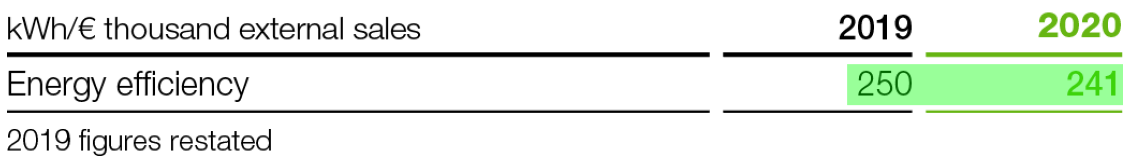

what's the value of Scope 2 Emissions Location-based in 2020?


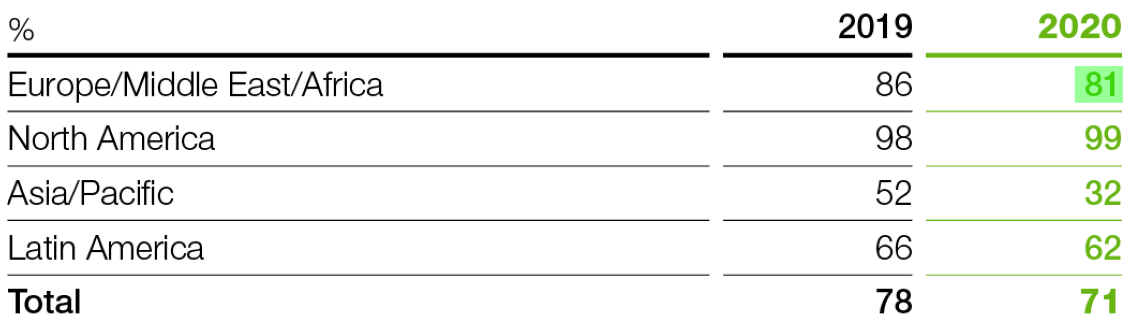

what's the value of Scope 2 Emissions Market-based in 2020?


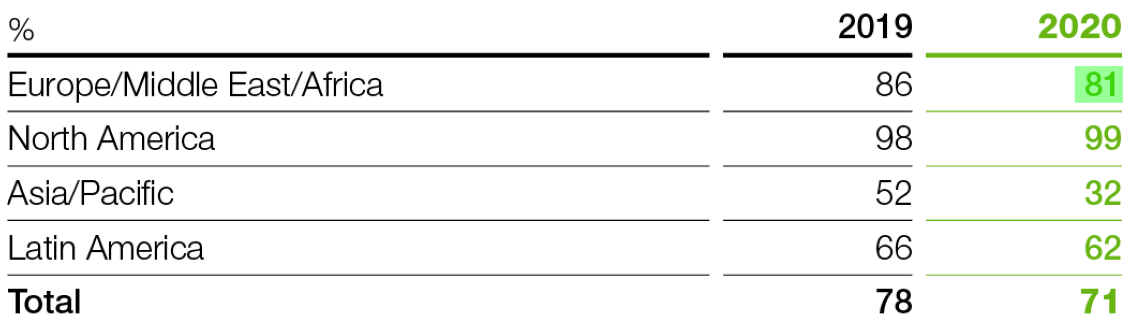

what's the value of Scope 3 Emissions in Tons in 2020?


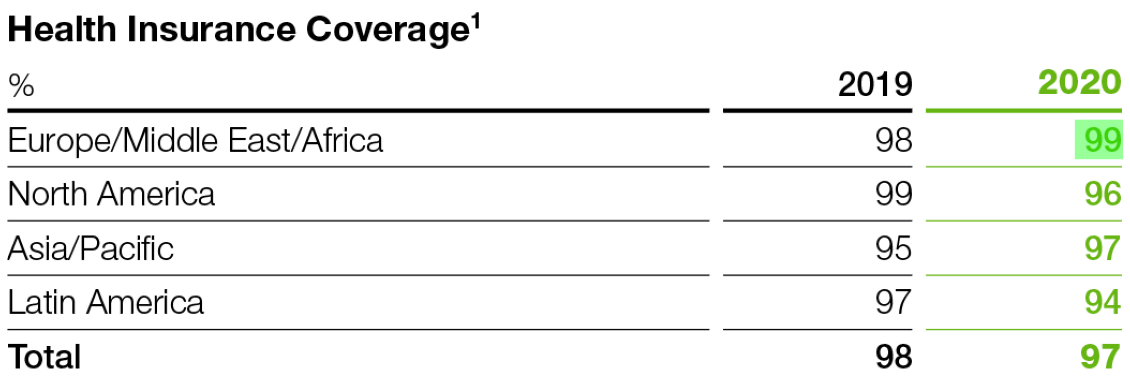

what's the value of Total amount of Waste Produced in 2020?


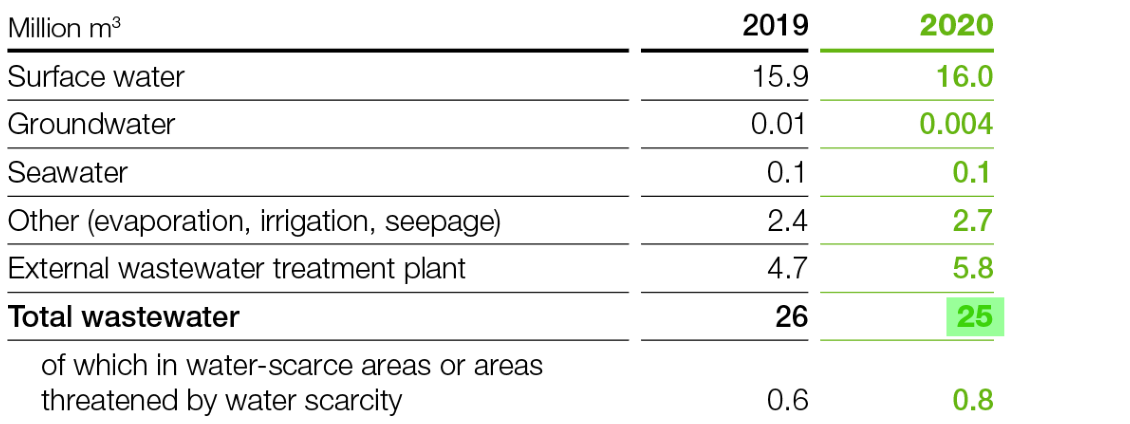

what's the value of Total hazardous waste in 2020?


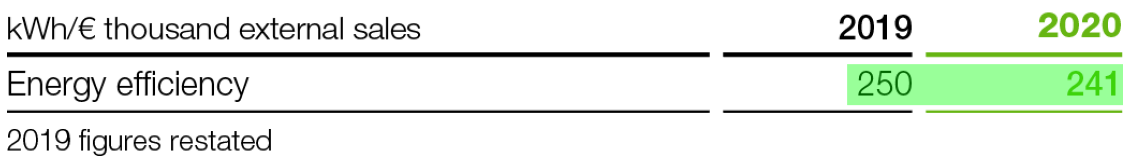

what's the value of Total water usage in 2020?


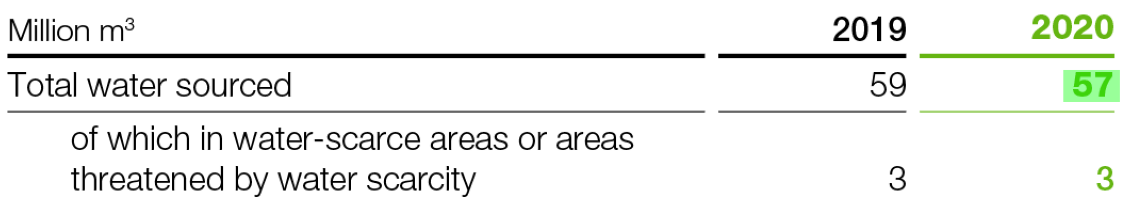

what's the value of number of Employees in 2020?


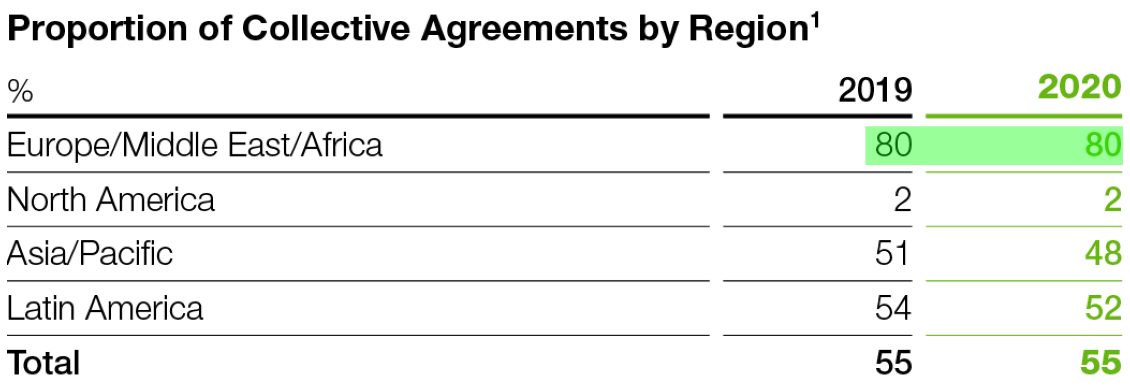

In [ ]:
bayer_answers=App(
    pdf_path="/content/Bayer-Sustainability-Report-2020.pdf",
    quries= ["what's the value of Scope 1 Emissions in 2020?",
                "what's the value of Scope 2 Emissions Location-based in 2020?",
                "what's the value of Scope 2 Emissions Market-based in 2020?",
                "what's the value of Scope 3 Emissions in Tons in 2020?",
                "what's the value of Total amount of Waste Produced in 2020?",
                "what's the value of Total hazardous waste in 2020?",
                "what's the value of Total water usage in 2020?",
                "what's the value of number of Employees in 2020?"]
    )

display(bayer_answers)
preview_all_answers(bayer_answers)

Downloading...
From: https://drive.google.com/uc?id=16QozC9c7Sxu4wGE6k4LA-nxn_-Z54CJy
To: /content/PDFServicesSDK-Python (Extract)Samples.zip
100%|██████████| 613k/613k [00:00<00:00, 120MB/s]


The Image Tables saved to : Microsoft_Environmental_Sustainability_Report_2020/tables


  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/transformers/pipelines/base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/pandas/core/dtypes/cast.py:881: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  element = np.asarray(element)
100%|██████████| 8/8 [06:59<00:00, 52.38s/it]


answer     score  \
what's the value of Scope 1 Emissions in 2020?         11  0.111976   
what's the value of Scope 2 Emissions Location-...     12  0.126907   
what's the value of Scope 2 Emissions Market-ba...     12  0.045725   
what's the value of Scope 3 Emissions in Tons i...     19  0.606736   
what's the value of Total amount of Waste Produ...      5  0.026923   
what's the value of Total hazardous waste in 2020?     85  0.832266   
what's the value of Total water usage in 2020?         11  0.125246   
what's the value of number of Employees in 2020?        5  0.312749   

                                                                                           table_path  \
what's the value of Scope 1 Emissions in 2020?      Microsoft_Environmental_Sustainability_Report_...   
what's the value of Scope 2 Emissions Location-...  Microsoft_Environmental_Sustainability_Report_...   
what's the value of Scope 2 Emissions Market-ba...  Microsoft_Environmental_Sustainability_Report_...   
what's the value of Scope 3 Emissions in Tons i...  Microsoft_Environmental_Sustainability_Report_...   
what's the value of Total amount of Waste Produ...  Microsoft_Environmental_Sustainability_Report_...   
what's the value of Total hazardous waste in 2020?  Microsoft_Environmental_Sustainability_Report_...   
what's the value of Total water usage in 2020?      Microsoft_Environmental_Sustainability_Report_...   
what's the value of number of Employees in 2020?    Microsoft_Environmental_Sustainability_Report_...   

                                                   mapped_answer_loaction  
what's the value of Scope 1 Emissions in 2020?                       [13]  
what's the value of Scope 2 Emissions Location-...                   [15]  
what's the value of Scope 2 Emissions Market-ba...                   [15]  
what's the value of Scope 3 Emissions in Tons i...                   [10]  
what's the value of Total amount of Waste Produ...                    [3]  
what's the value of Total hazardous waste in 2020?                   [17]  
what's the value of Total water usage in 2020?                       [13]  
what's the value of number of Employees in 2020?                      [3]

what's the value of Scope 1 Emissions in 2020?


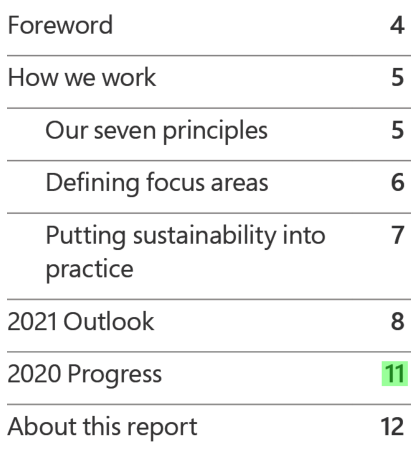

what's the value of Scope 2 Emissions Location-based in 2020?


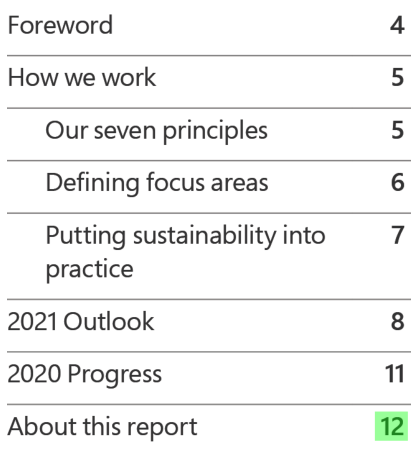

what's the value of Scope 2 Emissions Market-based in 2020?


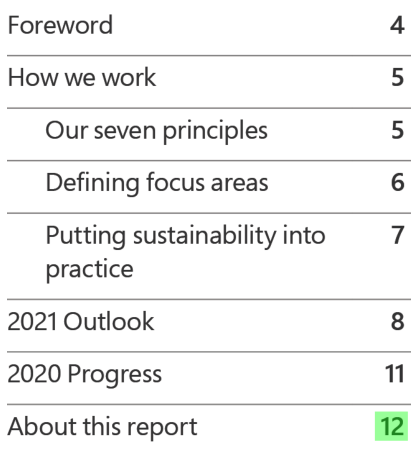

what's the value of Scope 3 Emissions in Tons in 2020?


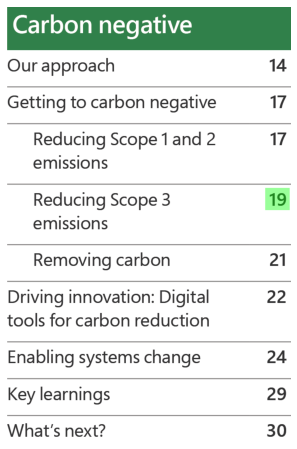

what's the value of Total amount of Waste Produced in 2020?


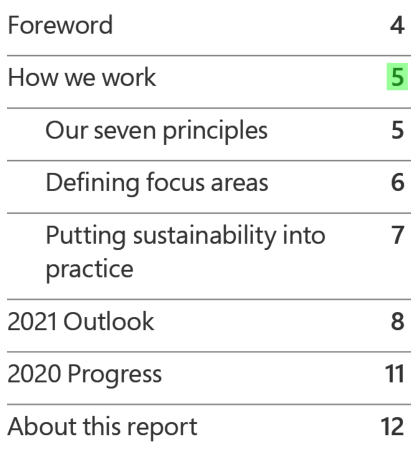

what's the value of Total hazardous waste in 2020?


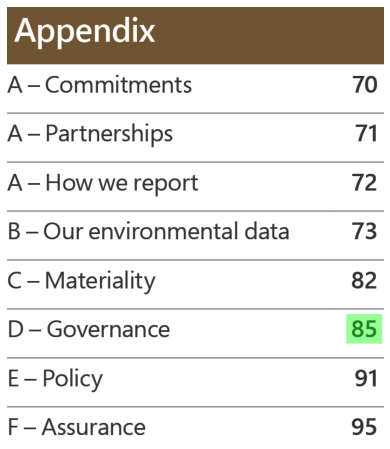

what's the value of Total water usage in 2020?


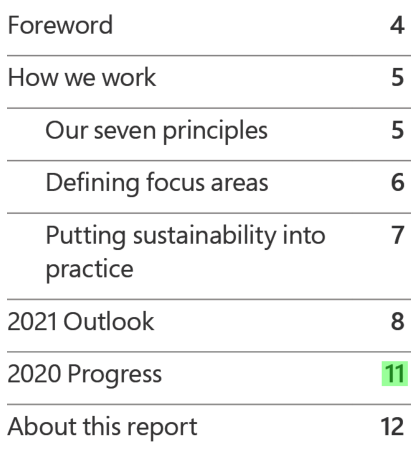

what's the value of number of Employees in 2020?


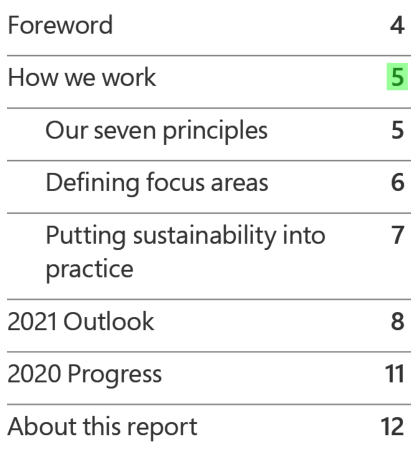

In [ ]:
microsoft_answers=App(
    pdf_path="/content/Microsoft_Environmental_Sustainability_Report_2020.pdf",
    quries= ["what's the value of Scope 1 Emissions in 2020?",
                "what's the value of Scope 2 Emissions Location-based in 2020?",
                "what's the value of Scope 2 Emissions Market-based in 2020?",
                "what's the value of Scope 3 Emissions in Tons in 2020?",
                "what's the value of Total amount of Waste Produced in 2020?",
                "what's the value of Total hazardous waste in 2020?",
                "what's the value of Total water usage in 2020?",
                "what's the value of number of Employees in 2020?"]
    )

display(microsoft_answers)
preview_all_answers(microsoft_answers)

Downloading...
From: https://drive.google.com/uc?id=16QozC9c7Sxu4wGE6k4LA-nxn_-Z54CJy
To: /content/PDFServicesSDK-Python (Extract)Samples.zip
100%|██████████| 613k/613k [00:00<00:00, 91.0MB/s]


The Image Tables saved to : 2021_Sustainability_Report/tables


  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/transformers/pipelines/base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/pandas/core/dtypes/cast.py:881: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  element = np.asarray(element)
100%|██████████| 8/8 [10:27<00:00, 78.39s/it]


answer     score  \
what's the value of Scope 1 Emissions in 2020?        427  0.992608   
what's the value of Scope 2 Emissions Location-...    427  0.997493   
what's the value of Scope 2 Emissions Market-ba...    427  0.996011   
what's the value of Scope 3 Emissions in Tons i...    427  0.998345   
what's the value of Total amount of Waste Produ...    417  0.776861   
what's the value of Total hazardous waste in 2020?      0  0.998939   
what's the value of Total water usage in 2020?          0  0.987192   
what's the value of number of Employees in 2020?      427  0.997949   

                                                                                           table_path  \
what's the value of Scope 1 Emissions in 2020?      2021_Sustainability_Report/tables/fileoutpart9...   
what's the value of Scope 2 Emissions Location-...  2021_Sustainability_Report/tables/fileoutpart9...   
what's the value of Scope 2 Emissions Market-ba...  2021_Sustainability_Report/tables/fileoutpart9...   
what's the value of Scope 3 Emissions in Tons i...  2021_Sustainability_Report/tables/fileoutpart9...   
what's the value of Total amount of Waste Produ...  2021_Sustainability_Report/tables/fileoutpart1...   
what's the value of Total hazardous waste in 2020?  2021_Sustainability_Report/tables/fileoutpart1...   
what's the value of Total water usage in 2020?      2021_Sustainability_Report/tables/fileoutpart1...   
what's the value of number of Employees in 2020?    2021_Sustainability_Report/tables/fileoutpart9...   

                                                   mapped_answer_loaction  
what's the value of Scope 1 Emissions in 2020?                        [8]  
what's the value of Scope 2 Emissions Location-...                    [8]  
what's the value of Scope 2 Emissions Market-ba...                    [8]  
what's the value of Scope 3 Emissions in Tons i...                    [8]  
what's the value of Total amount of Waste Produ...                    [6]  
what's the value of Total hazardous waste in 2020?                   [11]  
what's the value of Total water usage in 2020?                       [11]  
what's the value of number of Employees in 2020?                      [8]

what's the value of Scope 1 Emissions in 2020?


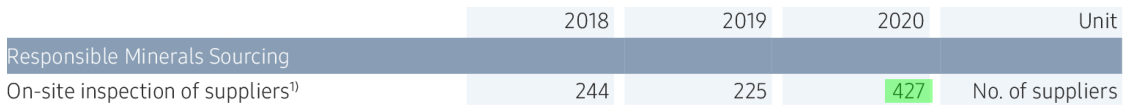

what's the value of Scope 2 Emissions Location-based in 2020?


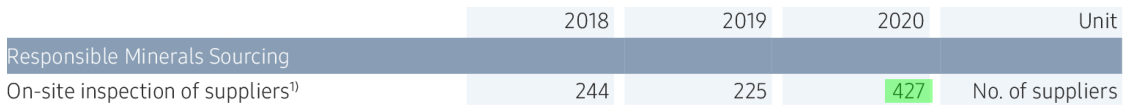

what's the value of Scope 2 Emissions Market-based in 2020?


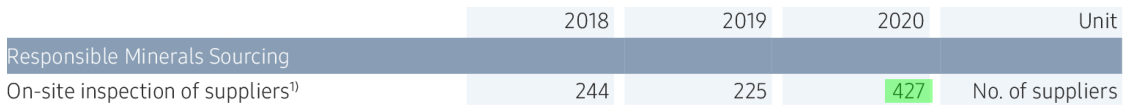

what's the value of Scope 3 Emissions in Tons in 2020?


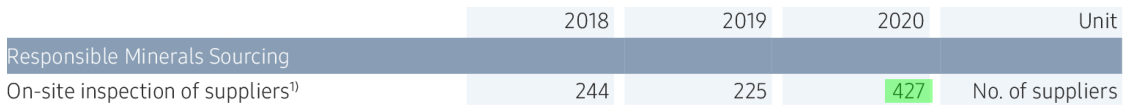

what's the value of Total amount of Waste Produced in 2020?


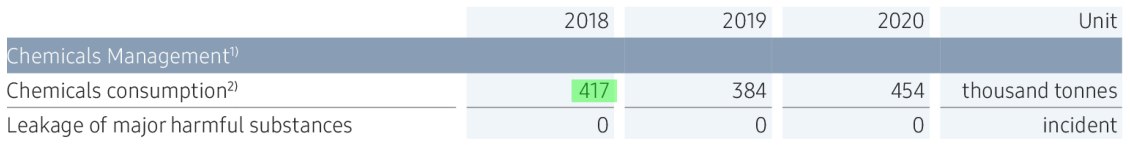

what's the value of Total hazardous waste in 2020?


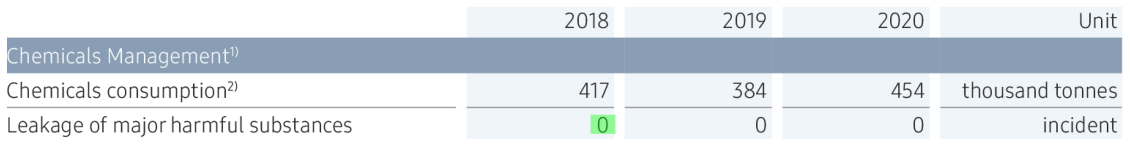

what's the value of Total water usage in 2020?


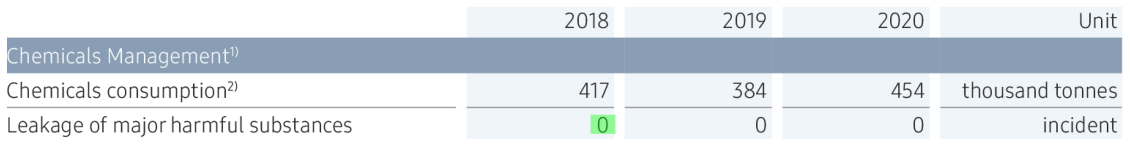

what's the value of number of Employees in 2020?


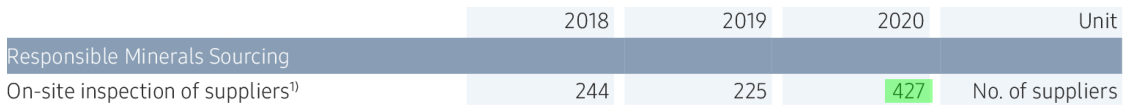

In [ ]:
SAMSUNG_answers=App(
    pdf_path="/content/2021_Sustainability_Report.pdf",
    quries= ["what's the value of Scope 1 Emissions in 2020?",
                "what's the value of Scope 2 Emissions Location-based in 2020?",
                "what's the value of Scope 2 Emissions Market-based in 2020?",
                "what's the value of Scope 3 Emissions in Tons in 2020?",
                "what's the value of Total amount of Waste Produced in 2020?",
                "what's the value of Total hazardous waste in 2020?",
                "what's the value of Total water usage in 2020?",
                "what's the value of number of Employees in 2020?"]
    )

display(SAMSUNG_answers)
preview_all_answers(SAMSUNG_answers)

Downloading...
From: https://drive.google.com/uc?id=16QozC9c7Sxu4wGE6k4LA-nxn_-Z54CJy
To: /content/PDFServicesSDK-Python (Extract)Samples.zip
100%|██████████| 613k/613k [00:00<00:00, 76.6MB/s]


The Image Tables saved to : pmi-integrated-report-2020/tables


  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/transformers/pipelines/base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/pandas/core/dtypes/cast.py:881: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  element = np.asarray(element)
100%|██████████| 8/8 [08:23<00:00, 62.91s/it]


answer     score  \
what's the value of Scope 1 Emissions in 2020?         33  0.722844   
what's the value of Scope 2 Emissions Location-...    100  0.942759   
what's the value of Scope 2 Emissions Market-ba...    100  0.754243   
what's the value of Scope 3 Emissions in Tons i...     33  0.940866   
what's the value of Total amount of Waste Produ...     48  0.670350   
what's the value of Total hazardous waste in 2020?     33  0.143219   
what's the value of Total water usage in 2020?         48  0.008968   
what's the value of number of Employees in 2020?        4  0.630266   

                                                                                           table_path  \
what's the value of Scope 1 Emissions in 2020?      pmi-integrated-report-2020/tables/fileoutpart7...   
what's the value of Scope 2 Emissions Location-...  pmi-integrated-report-2020/tables/fileoutpart5...   
what's the value of Scope 2 Emissions Market-ba...  pmi-integrated-report-2020/tables/fileoutpart5...   
what's the value of Scope 3 Emissions in Tons i...  pmi-integrated-report-2020/tables/fileoutpart7...   
what's the value of Total amount of Waste Produ...  pmi-integrated-report-2020/tables/fileoutpart5...   
what's the value of Total hazardous waste in 2020?  pmi-integrated-report-2020/tables/fileoutpart7...   
what's the value of Total water usage in 2020?      pmi-integrated-report-2020/tables/fileoutpart5...   
what's the value of number of Employees in 2020?    pmi-integrated-report-2020/tables/fileoutpart4...   

                                                   mapped_answer_loaction  
what's the value of Scope 1 Emissions in 2020?                        [5]  
what's the value of Scope 2 Emissions Location-...                   [24]  
what's the value of Scope 2 Emissions Market-ba...                   [24]  
what's the value of Scope 3 Emissions in Tons i...                    [5]  
what's the value of Total amount of Waste Produ...                   [52]  
what's the value of Total hazardous waste in 2020?                    [5]  
what's the value of Total water usage in 2020?                       [52]  
what's the value of number of Employees in 2020?                     [61]

what's the value of Scope 1 Emissions in 2020?


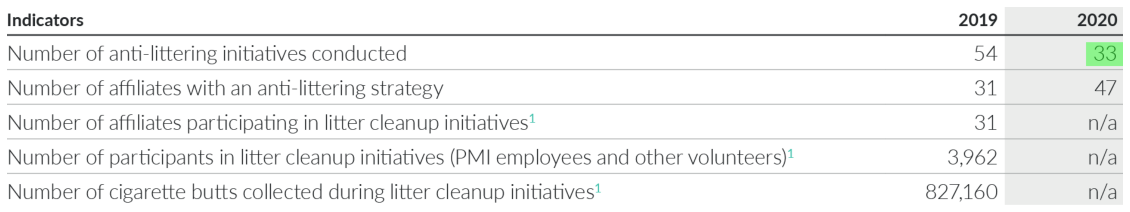

what's the value of Scope 2 Emissions Location-based in 2020?


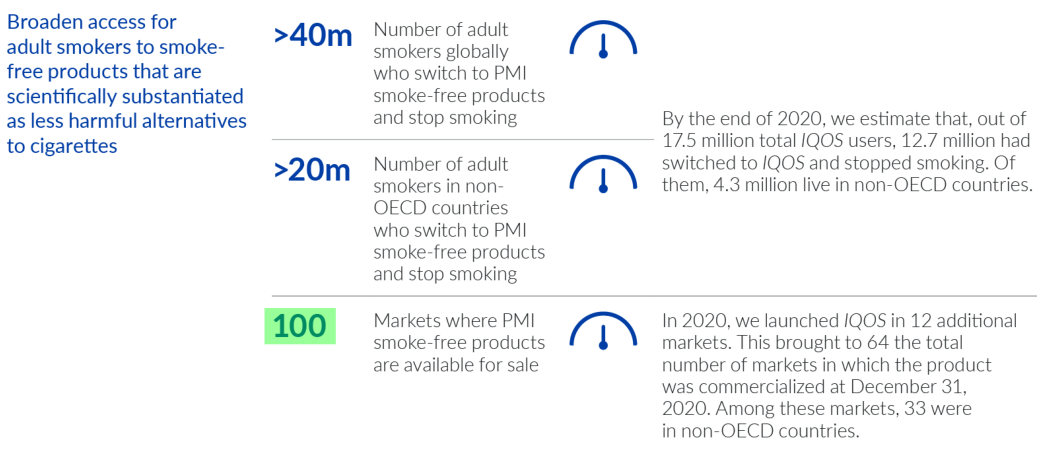

what's the value of Scope 2 Emissions Market-based in 2020?


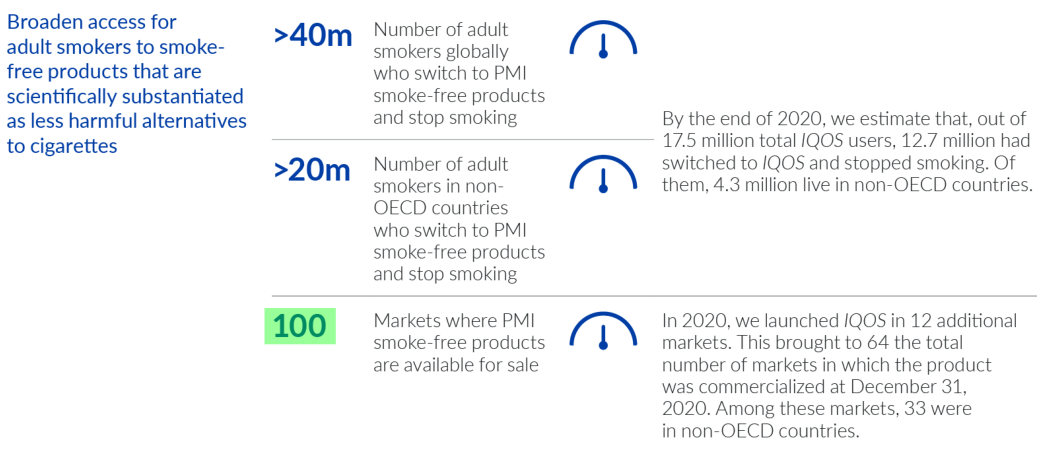

what's the value of Scope 3 Emissions in Tons in 2020?


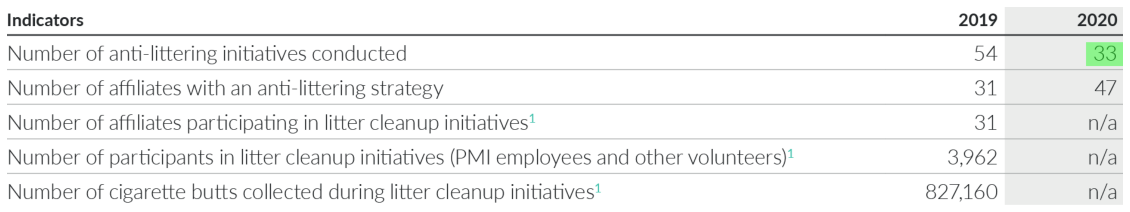

what's the value of Total amount of Waste Produced in 2020?


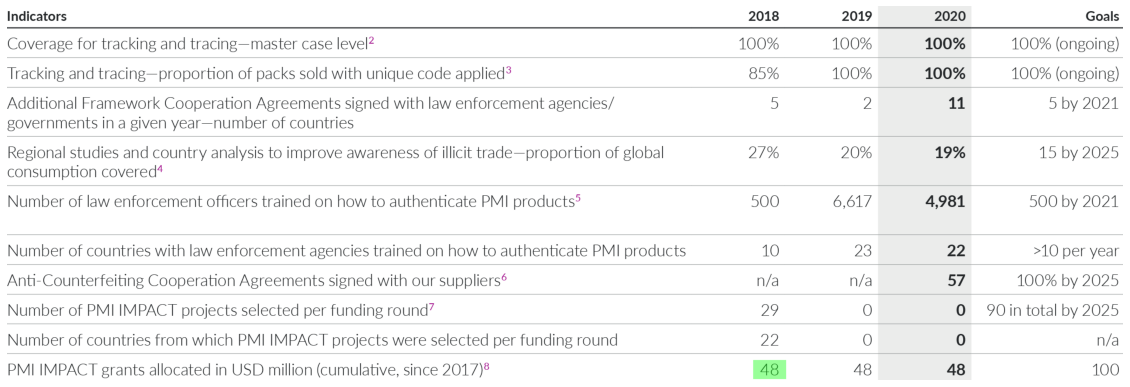

what's the value of Total hazardous waste in 2020?


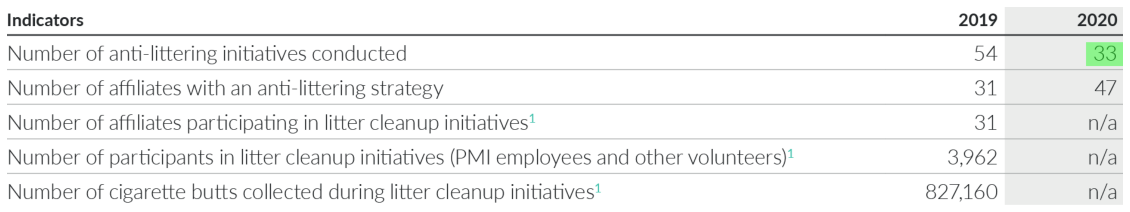

what's the value of Total water usage in 2020?


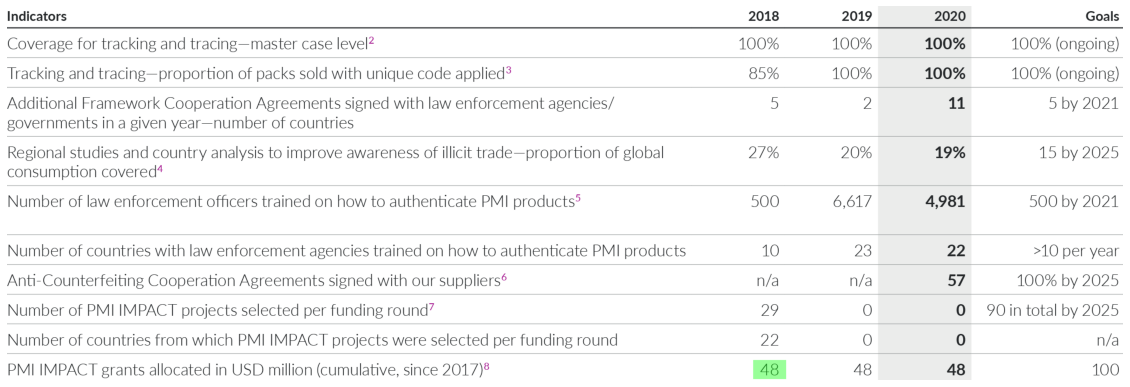

what's the value of number of Employees in 2020?


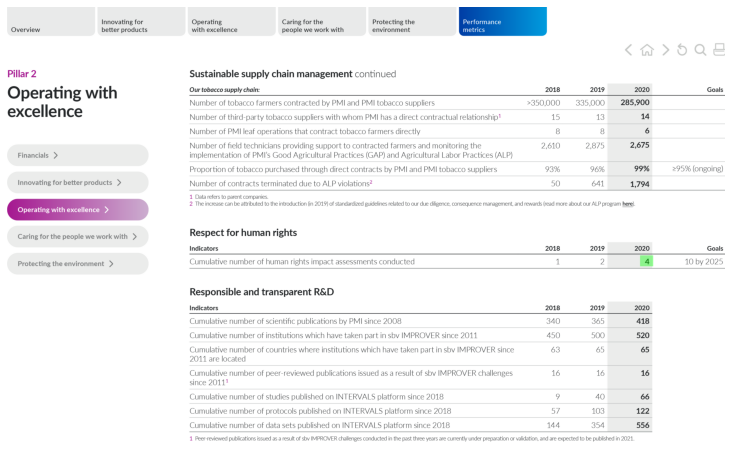

In [ ]:
Philip_Morris_answers=App(
    pdf_path="/content/pmi-integrated-report-2020.pdf",
    quries= ["what's the value of Scope 1 Emissions in 2020?",
                "what's the value of Scope 2 Emissions Location-based in 2020?",
                "what's the value of Scope 2 Emissions Market-based in 2020?",
                "what's the value of Scope 3 Emissions in Tons in 2020?",
                "what's the value of Total amount of Waste Produced in 2020?",
                "what's the value of Total hazardous waste in 2020?",
                "what's the value of Total water usage in 2020?",
                "what's the value of number of Employees in 2020?"]
    )

display(Philip_Morris_answers)
preview_all_answers(Philip_Morris_answers)